In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

In [2]:
mb_size = 64
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

train_data = torchvision.datasets.MNIST('/home/davidpqc1231/GAN/Paper', download=True, transform=transform, train = True)
train_loader = DataLoader(train_data, shuffle=True, batch_size=mb_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


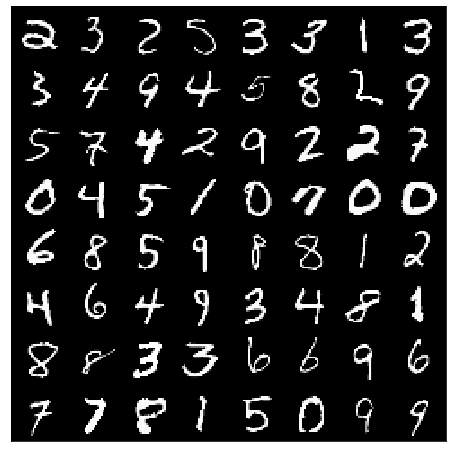

torch.Size([64, 1, 28, 28])


In [3]:
dataiter = iter(train_loader)
imgs, labels = dataiter.next()

def imshow(imgs):
    """ Visualizing images """
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming tensors to numpy arrays
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

print(imgs.size())

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [5]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [6]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Linear(100,128*7*7),
            nn.ReLU()
        )
            
        self.model2 = nn.Sequential( 
            nn.ConvTranspose2d(in_channels=128,out_channels=64, 
                               kernel_size=2,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=64,out_channels=1, 
                               kernel_size=2,stride=2),
            nn.Tanh()
        )
             
        self.model1.apply(xavier_init)
        self.model2.apply(xavier_init)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.model1(x)
        y_ = y_.view(y_.size(0), 128, 7, 7)
        y_ = self.model2(y_)
        return y_
    
test1 = Gen()
print(test1)

Gen(
  (model1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (model2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (4): Tanh()
  )
)


In [7]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=64,
                      kernel_size=3,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64,out_channels=16,
                      kernel_size=3,stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2,stride=1)
        )
        
        self.model2 = nn.Sequential(
            nn.Linear(16*5*5,1),
            nn.Sigmoid()
        )
            
        self.model1.apply(xavier_init)
        self.model2.apply(xavier_init)
    
    def forward(self, x):
        y_ = self.model1(x)
        y_ = y_.view(y_.size(0),-1)
        y_ = self.model2(y_)
        return y_
    
test2 = Dis()
print(test2)

Dis(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (model2): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [8]:
criterion = nn.BCELoss()
G = Gen().to(DEVICE)
D = Dis().to(DEVICE)


In [9]:
z = torch.randn(64,100).to(DEVICE)
print(G(z).shape)

print(D(G(z)).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


In [10]:
G

Gen(
  (model1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (model2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (4): Tanh()
  )
)

In [11]:
D

Dis(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (model2): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [12]:
G_opt = opt.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_opt = opt.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
G_losses = []
D_losses = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1,   G_loss:1.1595613956451416,   D_loss:1.0632705688476562


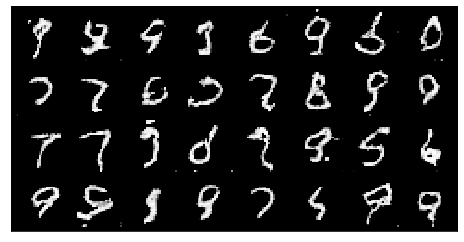

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2,   G_loss:0.5811524391174316,   D_loss:1.7256513833999634


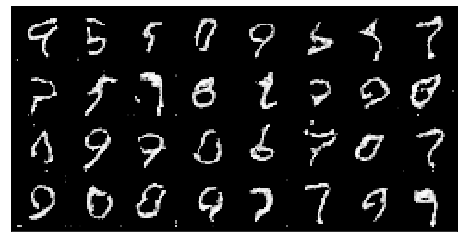

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3,   G_loss:0.8477634191513062,   D_loss:1.0523927211761475


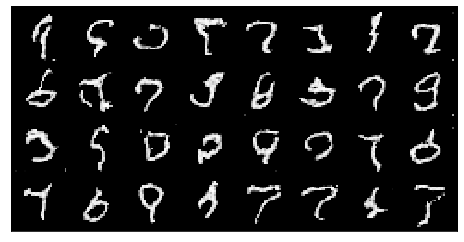

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4,   G_loss:0.9212974309921265,   D_loss:1.3696212768554688


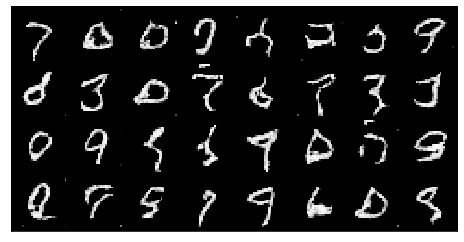

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5,   G_loss:0.8907941579818726,   D_loss:1.684438705444336


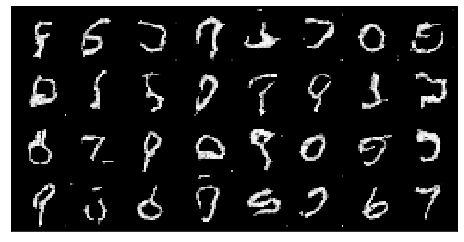

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6,   G_loss:0.8517118692398071,   D_loss:1.0903594493865967


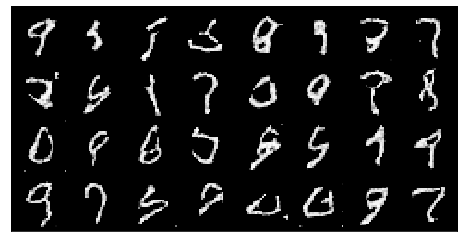

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7,   G_loss:0.9722684621810913,   D_loss:1.1473970413208008


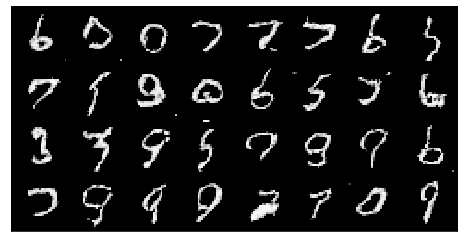

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8,   G_loss:0.9681125283241272,   D_loss:1.176025629043579


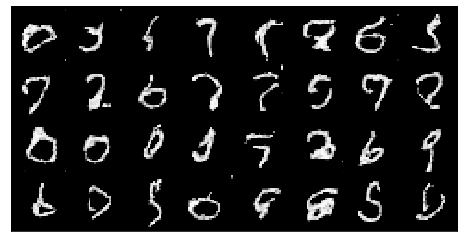

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9,   G_loss:0.6267288327217102,   D_loss:1.2288230657577515


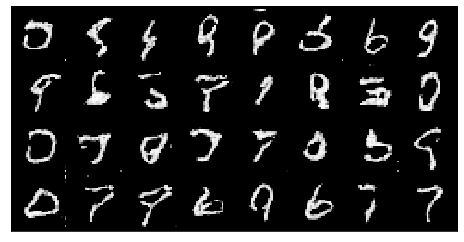

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10,   G_loss:0.9276686310768127,   D_loss:1.3678683042526245


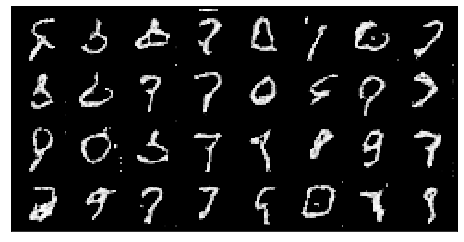

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11,   G_loss:1.167232632637024,   D_loss:1.1940813064575195


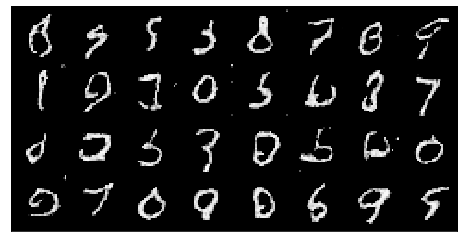

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12,   G_loss:0.7442172765731812,   D_loss:1.2763012647628784


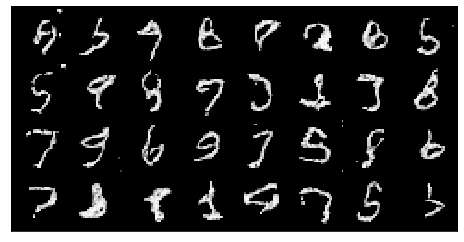

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13,   G_loss:0.7656590938568115,   D_loss:1.2556687593460083


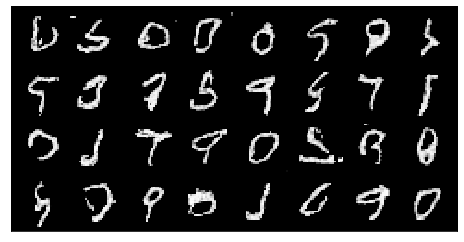

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14,   G_loss:0.6500669121742249,   D_loss:1.1871118545532227


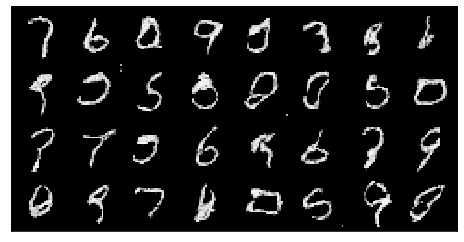

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15,   G_loss:0.6928244829177856,   D_loss:1.2865159511566162


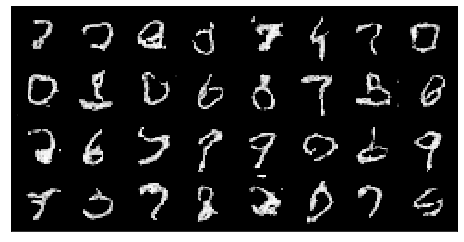

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16,   G_loss:0.8663025498390198,   D_loss:1.261892318725586


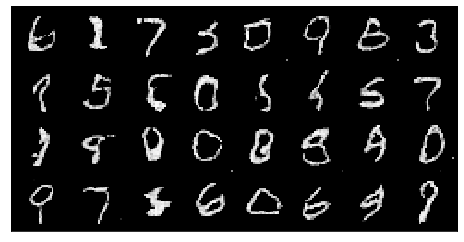

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17,   G_loss:0.9804377555847168,   D_loss:1.3464088439941406


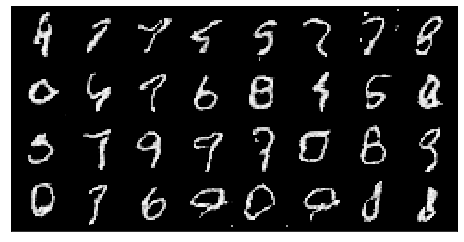

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18,   G_loss:1.0916354656219482,   D_loss:1.361660361289978


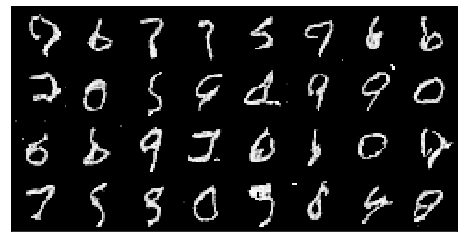

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19,   G_loss:1.0792138576507568,   D_loss:1.295107364654541


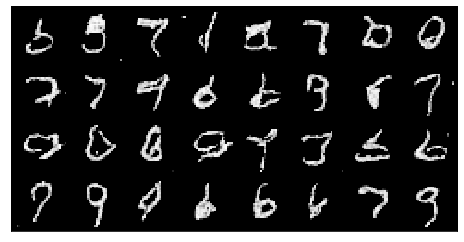

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20,   G_loss:1.0826821327209473,   D_loss:1.1446040868759155


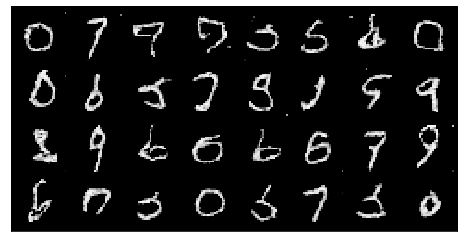

In [18]:
for epoch in range(20):
    for idx, (images, labels) in enumerate(train_loader):
        
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        batch_size = x.size(0)
        D_labels = torch.ones(batch_size, 1).to(DEVICE)
        D_fakes = torch.zeros(batch_size, 1).to(DEVICE)
        D_x_loss = criterion(x_outputs, D_labels)
        
        z = torch.randn(batch_size, 100).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        D_losses.append(D_loss.item())
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, 100).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = criterion(z_outputs, D_labels)
        G_losses.append(G_loss.item())

        D.zero_grad()
        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
    # printing loss after each epoch 
    print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch+1, G_loss.item(), D_loss.item() ))
    
    # Plotting fake images generated after each epoch by generator
    samples = G(z).detach()
    samples = samples.cpu()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imshow(samples)

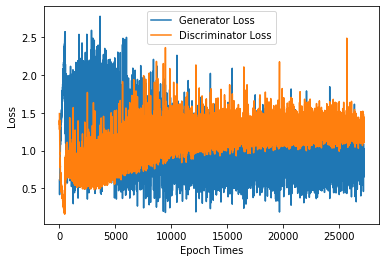

In [19]:
plt.plot(G_losses,label='Generator Loss')
plt.plot(D_losses,label='Discriminator Loss')
plt.legend()
plt.xlabel('Epoch Times')
plt.ylabel('Loss')
plt.show()